## INFO

This is a notebook to highlight the Tweedie Compound Poisson Gamma (TCPG) ealstic net that was developed byt he Data Science team based on the following:

- https://cran.r-project.org/web/packages/HDtweedie/HDtweedie.pdf
- https://www.math.mcgill.ca/yyang/resources/papers/JCGS_HDtweedie.pdf

The elastic net code should be provided as well and it uses a "Fish" data set that is considered a useful test set. 

Please note that TCPG is only valid for solutions of powers between 1.0 and 2.0.

<font color=red size=4>**This version is straight  forward and only compares results.**</font>


<font color=blue size=4>**Links for comparison to SAS:**</font>

- https://stats.stackexchange.com/questions/400663/sas-and-r-gives-different-standard-error-when-fitting-tweedie-model

- *GEE Models not available for Tweedie Distribution*


<font color=green size=4>**This version is for comparing profile generators for optimal tweedie power. 2022-03-04**</font>

In [1]:
## SOME EXTENSIONS MIGHT NOT LOAD 
%load_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sma
import scipy as sp

from sklearn.metrics import mean_tweedie_deviance, mean_absolute_error

import os
import gc

import shap
import eli5

pd.set_option('max_columns', 150)
pd.set_option('max_rows', 100)

In [3]:
import os
##  you must then set your R HOME before importing the module - it should be in a similar location as below

os.environ['R_HOME'] = 'C:/Users/schillw/Anaconda3/envs/fnb/Lib/R'


**As long as the environment part of the path above - the "fnb" matches your environment that you are working in.**

In [4]:
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2 import robjects
import rpy2
pandas2ri.activate()

import sys
print("Python version should be 3.7.9.")
print("Current Python Version: {}".format(sys.version))
print("rpy2 Version = ", rpy2.__version__)

print("\nR VERSION = ", r.version)

Python version should be 3.7.9.
Current Python Version: 3.7.9 (default, Aug 31 2020, 17:10:11) [MSC v.1916 64 bit (AMD64)]
rpy2 Version =  3.4.5

R VERSION =                 _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          3                           
minor          6.3                         
year           2020                        
month          02                          
day            29                          
svn rev        77875                       
language       R                           
version.string R version 3.6.3 (2020-02-29)
nickname       Holding the Windsock        



In [5]:
from fnbbase.models import TweedieElasticNet

## Fish Data

I cant find the link but there are 5 variables where FISH_COUNT is our dependent variable based on how many were caught.

In [6]:
fish_data = pd.read_csv('data/fish.csv')
fish_data.head()

LIVE_BAIT  CAMPER  PERSONS  CHILDREN  FISH_COUNT
0          0       0        1         0           0
1          1       1        1         0           0
2          1       0        1         0           0
3          1       1        2         1           0
4          1       0        1         0           1

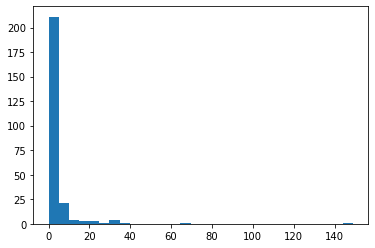

In [7]:
xf = fish_data.drop('FISH_COUNT',axis=1)
yf = fish_data['FISH_COUNT']

plt.hist(yf, bins=30);

**Here we see the distribution of the fishing data highlighting that it has a mass at zero and is discrete.**

In [8]:
(yf == 0).sum() / len(yf)

0.568

The data is about 56.8% 0.

**We must scale the exogenous variables (all others but y) to get an accurate assessment.**

In [9]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X = xf.copy() #ss.fit_transform(xf) #x.values
y = yf.values.reshape(-1,1)

xfs = pd.DataFrame(X, columns=xf.columns, index=xf.index)

xf.describe()

LIVE_BAIT      CAMPER    PERSONS    CHILDREN
count  250.000000  250.000000  250.00000  250.000000
mean     0.864000    0.588000    2.52800    0.684000
std      0.343476    0.493182    1.11273    0.850315
min      0.000000    0.000000    1.00000    0.000000
25%      1.000000    0.000000    2.00000    0.000000
50%      1.000000    1.000000    2.00000    0.000000
75%      1.000000    1.000000    4.00000    1.000000
max      1.000000    1.000000    4.00000    3.000000

### STATSMODELS - PYTHON

In [10]:
## intial estimation, HC3 error

p0 = 1.5

twd = sma.GLM(endog=y, exog=sma.add_constant(xfs), family=sma.families.Tweedie(var_power=p0, eql=True))
res = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      245
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    log   Scale:                          7.4412
Method:                          IRLS   Log-Likelihood:                -553.55
Date:                Mon, 21 Mar 2022   Deviance:                       859.06
Time:                        10:11:38   Pearson chi2:                 1.82e+03
No. Iterations:                    21                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0817      0.452     -6.824      0.0

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


**ReEstimate Tweedie Power**

In [11]:
print("Estimated Tweedie Power using R Method Built into TweedieElasticNet")
etp = TweedieElasticNet.r_tweedie_power_est(yf, sma.add_constant(xfs), figsize=None)
print(etp[0])

Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.
1.4102040816326533


In [12]:
twd.estimate_tweedie_power(res.mu)

1.630742735857726

116.74432130849385


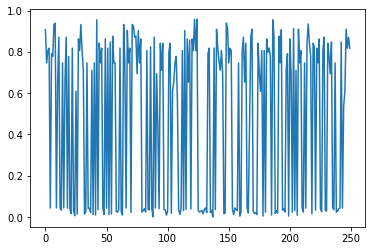

In [17]:
import tweedie_dist
import scipy as sp
twdgen = tweedie_dist.tweedie_gen()

## pdf according to quackdaddy
# density = twdgen._pdf(yf, p0, res.mu, res.scale)
density = tweedie_dist.tweedie(mu=res.mu, p=p0, phi=res.scale).pdf(yf)
print(density.sum())
plt.plot(density);

In [18]:
def loglike_p(p, res):
    return -tweedie_dist.tweedie(mu=res.mu, p=p, phi=res.scale).logpdf(res._endog).sum()

def optm(p, res):
    opt = sp.optimize.minimize_scalar(loglike_p, tol=1e-12, 
                                      bounds=(1.05, 1.95), args=(res), method='bounded')
    return opt

print(optm(p0, res))

     fun: 442.7833632815515
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 1.5403113885983206


Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


- https://github.com/thequackdaddy/statsmodels/blob/estimate_tweedie/statsmodels/genmod/generalized_linear_model.py

**In Dunn Smyth paper:**
- phi = dispersion
- mu = mean of distribution

- for series expansion:
    - alpha = shape parameter
    - gamma = scale parameter

In [37]:
mu = res.mu
p = 1.5
phi = estimate_x2_scale(res.model.endog, mu, 1.5, res.model.iweights)
dens = tweedie_dist.tweedie(mu=mu, p=1.5, phi=disp).pdf(res.model.endog)

In [38]:
lam = mu**(2-p)/(phi*(2-p))
alp = (2-p)/(1-p)
gam = phi*(p-1)*mu**(p-1)

In [39]:
lam, alp, gam

(array([0.09963754, 0.2986539 , 0.21992499, 0.20516207, 0.21992499,
        0.23904659, 0.25624776, 0.07129535, 0.06385197, 0.2986539 ,
        0.434627  , 0.1409373 , 0.28663962, 0.63268542, 0.2986539 ,
        0.2986539 , 0.434627  , 0.1409373 , 0.20516207, 0.25624776,
        0.434627  , 1.45726337, 0.20516207, 0.5065529 , 0.8591746 ,
        0.5065529 , 1.45726337, 0.15107878, 0.21992499, 0.07129535,
        0.21992499, 0.34797952, 1.45726337, 0.59021508, 0.2986539 ,
        0.16899723, 0.20516207, 0.59021508, 0.34797952, 0.59021508,
        0.2986539 , 1.45726337, 0.04701979, 0.6602166 , 0.17603092,
        0.2986539 , 0.20516207, 0.21992499, 0.20516207, 0.15107878,
        0.20516207, 0.20516207, 1.45726337, 0.16899723, 0.8591746 ,
        0.13530585, 0.2986539 , 0.2986539 , 0.59021508, 0.2986539 ,
        0.37301922, 0.20516207, 0.15107878, 1.45726337, 0.07129535,
        0.2986539 , 0.21992499, 0.10378446, 0.2986539 , 0.20516207,
        0.8591746 , 0.07129535, 0.07975122, 0.14

In [19]:
def optimize_twd_pwr_qd(y, mu, p, weights):
    ## from quack daddy :
    ## https://github.com/thequackdaddy/statsmodels/blob/estimate_tweedie/statsmodels/genmod/generalized_linear_model.py
    from scipy.optimize import brentq, minimize_scalar
    ## no change in minimize or various methods

    def psi_p(power, scale, y, mu):
        psi = ((y - mu) ** 2 / (scale * (mu ** power)) - 1)
        psi *= np.log(mu) * weights
        return psi.sum()

    def estimate_x2_scale(y, mu, p):
        resid = np.power(y - mu, 2) * weights
        df_resid = len(y)
        return np.sum(resid / np.power(mu, p)) / df_resid

    def difference(p):
        scale = estimate_x2_scale(y, mu, p)
        new_p = brentq(psi_p, -100, 100., args=(scale, y, mu)) ##brenth and ridder same as brentq
        return np.abs(new_p - p)

    power = minimize_scalar(difference, bounds=(1.05, 1.95), method='bounded', tol=1e-20)
    
    return power

In [20]:
optimize_twd_pwr_qd(res.model.endog, res.mu, 1.5, res.model.iweights)

     fun: 3.6698855065964153e-09
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 1.6326041315726691

In [21]:
def estimate_x2_scale(y, mu, p, weights):
    resid = np.power(y - mu, 2) * weights
    df_resid = len(y)
    return np.sum(resid / np.power(mu, p)) / df_resid

def dispersion(y, yhat):
    '''sas genmod dispersion'''
    resid = y - yhat
    dof = len(y)
    disp = 1/(resid - dof - 1) * np.sum(resid**2)
    return disp

## x2 scale and dispersion above are essentially the same!

def sas_calc(y, yhat, p, phi, wi):
    sasq1 = -.5 * np.log(2*np.pi * phi * y**(p) / wi)
    sasq1 = np.where(~(np.isfinite(sasq1)), 0, sasq1)
    sasq2n = wi*(np.power(y,2-p) - (2-p)*y*np.power(yhat,1-p) + (1-p)*np.power(yhat,2-p))
    sasq2d = (1-p)*(1-p)
    sasq = sasq1 + (sasq2n/sasq2d) / phi
    return sasq

def deviance(y, mu, p):
    dev = np.power(y,2-p)/((1-p)*(2-p)) - \
            y*np.power(mu,1-p)/(1-p) + np.power(mu,2-p)/(2-p)
    return dev

def dtweedie(y, power, mu, phi):
    '''calculate density'''
    density = tweedie_dist.tweedie(mu=mu, p=power, phi=phi).pdf(y)
    print(density.sum())
#     density = tweedie_dist.tweedie(mu=mu, p=power, phi=phi).logpdf(y)
    return density

def dfdphi_saddle(y, mu, p, phi):
    dev = deviance(y, mu, p)
    df = (-1)/(2*phi) + dev/(2*ph**2)
    return -2 * np.sum(df)

def logw_smallp(power, y, phi):
    '''p is power, a is alp'''
    from scipy.special import gammaln, gamma
    
    p = power
    a = (2-p)/(1-p)
    a1 = 1 - a
    r = -a*np.log(y) + a*np.log(p-1) - a1*np.log(phi) - np.log(2-p) # All terms to power j

    drop = 37
    logz = max(r)   # To find largest  j  needed
    j_max = max( y**( 2-p ) / ( phi * (2-p) ) )
    j = max( 1, j_max )
    
    c = logz + a1 + a*np.log(-a)
    wmax = a1*j_max
    estlogw = wmax

    while estlogw > (wmax-drop):
        j = j + 2
        estlogw = j*(c - a1*np.log(j))    
    hi_j = np.ceil(j)

    logz = min(r) 
    j_max = min( y**( 2-power ) / ( phi * (2-power) ) )
    
    j = max(1, j_max)
    wmax = a1*j_max 
    estlogw = wmax 
    while (estlogw > (wmax-drop)) & (j>=2):
        j = max(1, j-2)
        oldestlogw = estlogw
        estlogw = j*(c-a1*np.log(j))   
    lo_j = max(1, np.floor(j))            

    j = np.arange(lo_j, hi_j + 1) ## j <- seq( lo.j, hi.j)  # sequence of j terms needed
    o = np.ones((len(y),1)) ## o <- matrix( 1, nrow=length(y))     # matrix of ones
    
    g = (gammaln(j+1) + gammaln(-a*j)).reshape(-1,1)  ## g <- matrix(lgamma( j+1 ) + lgamma( -a*j ), nrow=1, ncol=hi.j - lo.j + 1) 
    og = o.dot(g.T) ## logj <- matrix(log(j), nrow=1, ncol=hi.j - lo.j + 1) 

    A = np.outer(r,j) - og # + ologj # the series almost ready to sum   A <- outer(r,j) - og + ologj
    m = np.max(A, axis=1).reshape(-1,1) # avoid overflow, find max values  m <- apply(A,1,max)
    we = np.exp(A - m) ## we <- exp( A - m )  # evaluate terms, less max.
    we_sum = np.sum(we, axis=1) ## sum.we <- apply( we,1,sum)  # sum terms
    logw = np.log(we_sum) + m
    
    return hi_j, lo_j, j_max, logw

def dldphi(y, mu, power, phi):
    # Calculates the log-likelihood
    # function, wrt phi, for p>2.  In particular, it returns
    #    sum{ d(log f)/d(phi) } = d( log-likelihood )/d(phi).
    # The mle of phi can be found, therefore, by setting this to zero.
    # y  is generally a vector of observed values.

    #
    # Peter Dunn
    # 31 Jan 2001
    #
    ## removing annything outside of compound poisson
    
    k = phi**(1/(power-2))
    if (k < 1) & (k > 0):
        # Use the transform f(y; mu, phi) = c f(c*y; c*mu, c^(2-p)*phi)
        # and differentiate with c=phi^(1/(p-2)):
        #    d log f / d phi = c^(2-p) * {df(cy; c*mu, 1)/dphi} / f(cy; c*mu, 1)
        f = dtweedie( y=k*y, power=power, mu=k*mu, phi=1 )
        d = dlogfdphi( y=k*y, power=power, mu=k*mu, phi=1 )
        # Note:  We need dlogf/dphi = dlogf.dphi * f
        top = d * f
        d = -2* np.sum( top / f * k**(2-power) )
    else:
        #Compute directly
        print("compdir")
        d = -2*np.sum(dlogfdphi(y=y, power=power, mu=mu, phi=phi))
    return d

def dlogfdphi(y, mu, phi, power):
    # Calculates d(log f)/d(phi) for the Tweedie  densities.
    # It is used, for example, in mle fitting of phi.  We would then
    # sum over  y  and set this function to 0.
    #
    # Peter Dunn
    # 31 Jan 2001
    #
    phi = np.array([phi])

    p = power
    a = (2 - p)/(1 - p)
    if(len(phi) == 1):
        phi = phi*np.ones(len(y)) #array(dim = length(y), phi)
    if(len(mu) == 1):
        mu = mu = np.ones(len(y)) #array(dim = length(y), mu)
    
    A = (y * mu**(1 - p))/(phi**2 * (p - 1))
    B = mu**(2 - p)/(phi**2 * (2 - p))
  
    ## removed anything not related to compound poisson
    # if((power > 1) && (power < 2)) 
    # We need to treat y==0 separately.
    # We fill  f  with the Y=0 case
    f = mu**(2-power) / (phi**2 * (2-power)) * np.ones(len(y)) #array(  dim = length(y), mu^(2-power) / ( phi^2 * (2-power) )  )
    ygt0 = np.where(y>0,y,0)
    phigt0 = np.where(y>0, phi, 0)
    jw = jw_smallp(power, ygt0, phigt0)[-2]    #dtweedie.jw.smallp(power=power, phi=phi[y > 0], y=y[y > 0])$jw
    print(jw)
    dw_dphi = (jw*(a-1))/phigt0                  #(jw * (a - 1)) / phi[y > 0]
    logw = logw_smallp(power, ygt0, phigt0)[-1]
    #logw <- dtweedie.logw.smallp(power=power, phi=phi[y > 0], y=y[y > 0])$logw
    #f[y>0] <- A[y > 0] + B[y > 0] + dw.dphi/exp(logw)
    Agt0 = np.where(y>0, A, 0)
    Bgt0 = np.where(y>0, B, 0)
    fgt0 = Agt0 + Bgt0 + dw_dphi/np.exp(logw)
    
    f = np.where(y>0, fgt0, f)
    
    return f

In [24]:
phi = estimate_x2_scale(res.model.endog, res.mu, 1.5, res.model.iweights)
phi

7.292406290022506

In [26]:
phip = phi*np.ones(len(y))
lws = logw_smallp(1.5, np.where(res.model.endog > 0, res.model.endog, 0), 
                    np.where(res.model.endog > 0, phip, 0))

divide by zero encountered in log
invalid value encountered in subtract
invalid value encountered in true_divide
invalid value encountered in true_divide


In [30]:
np.nansum(lws[-1])

-16113.231532669179

In [242]:
dldphi(res.model.endog, res.mu, 1.5, res.scale)

278.8506741804098
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


divide by zero encountered in log
invalid value encountered in subtract
invalid value encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in log
invalid value encountered in subtract
invalid value encountered in true_divide
invalid value encountered in true_divide


nan

In [234]:
# np.where(res.model.endog>0,res.mu,0)

In [14]:
print(twd.scale, estimate_x2_scale(yf, res.mu, 1.5, twd.iweights), dispersion(yf, res.mu))

7.441230908186251 7.292406290022506 0     -89.725739
1     -89.350794
2     -89.543521
3     -89.573219
4     -89.900776
         ...    
245   -88.569160
246   -89.728370
247   -89.573219
248   -89.678569
249   -89.573219
Name: FISH_COUNT, Length: 250, dtype: float64


In [31]:
def tweedie_profile_sm(X, y, p, tolf=1e-20):
    tol0 = 1
    while tol0 > tolf:
        p0 = p
        mod = sma.GLM(endog=y, exog=X, family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
        res = mod.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
    
#         opt = sp.optimize.minimize_scalar(loglike_p, bounds=(1.05, 1.95), args=(res), method='bounded', tol=1e-20)
        p = twd.estimate_tweedie_power(res.mu)
        print(p)
        tol0 = p0 - p
    
    return p

tweedie_profile_sm(sma.add_constant(xfs), yf, p0)

1.630742735857726


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


1.630742735857726

**this is supposed to be the way from a statsmodels perspective...**

In [32]:
# help(tweedie_dist.estimate_tweedie_loglike_series)
tlls = tweedie_dist.estimate_tweedie_loglike_series(res.model.endog, res.mu, 
                                                     res.scale*np.ones(len(res.model.endog)), 
                                                     1.5*np.ones(len(res.model.endog)), )
tlls.sum()

-443.5555018880523

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


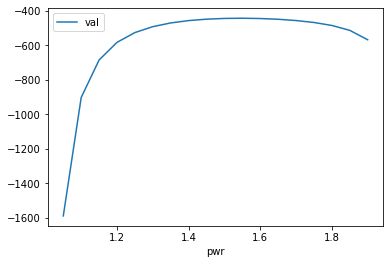

In [82]:

def tweedie_profile_r(X, y, p):
    ## d tweedie is density
    mod = sma.GLM(endog=y, exog=X, family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
    res = mod.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
    
#     phi = dispersion(res.model.endog, res.mu) ## doesnt even work here
    phi = res.scale
    density = tweedie_dist.tweedie(mu=res.mu, p=p, phi=phi).pdf(y)
#     nlogl = -2*np.sum(np.log(dtweedie(y, mu, phi, p)))
    nll = -2*np.sum(np.log(density))
    
    tlls = tweedie_dist.estimate_tweedie_loglike_series(res.model.endog, res.mu, 
                                                        res.scale*np.ones(len(res.model.endog)), 
                                                        p*np.ones(len(res.model.endog)), )
        
    return tlls.sum() #nll
#     phi_saddle = np.sum(deviance(y, mu, p))/len(y)

nlls = []
for p in np.arange(1.05,1.95,0.05):
    nll0 = tweedie_profile_r(sma.add_constant(xfs), yf, p)
    nlls.append([p,nll0])
    
pd.DataFrame(nlls, columns=['pwr','val']).set_index('pwr').plot();    

In [83]:
nlls

[[1.05, -1589.1354103697574],
 [1.1, -902.1639913656708],
 [1.1500000000000001, -684.5343097165241],
 [1.2000000000000002, -582.3095580342327],
 [1.2500000000000002, -525.5511807209899],
 [1.3000000000000003, -491.24161191919757],
 [1.3500000000000003, -469.66240339874804],
 [1.4000000000000004, -456.04671640205214],
 [1.4500000000000004, -447.8276581012037],
 [1.5000000000000004, -443.55550188805205],
 [1.5500000000000005, -442.4200670142508],
 [1.6000000000000005, -444.03279209382663],
 [1.6500000000000006, -448.3480659106658],
 [1.7000000000000006, -455.6973122418513],
 [1.7500000000000007, -466.9868664402276],
 [1.8000000000000007, -484.2776847526658],
 [1.8500000000000008, -512.5877645059609],
 [1.9000000000000008, -567.1527994479696]]

**for whatever reason, this method just sits in the bottom of the bucket everytime.**

**ReEstimate Using Tweedie Dist Method within Python from QuackDaddy**

116.74432130849385


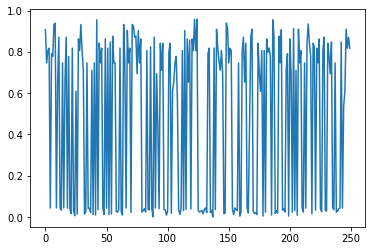

In [17]:
import tweedie_dist
import scipy as sp
twdgen = tweedie_dist.tweedie_gen()

## pdf according to quackdaddy
# density = twdgen._pdf(yf, p0, res.mu, res.scale)
density = tweedie_dist.tweedie(mu=res.mu, p=p0, phi=res.scale).pdf(yf)
print(density.sum())
plt.plot(density);

-443.5555018880523
-66.2485871625141


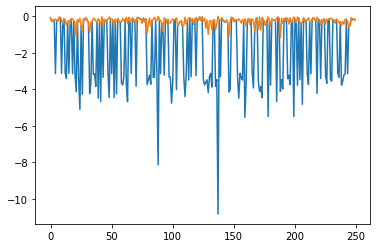

In [18]:
# help(tweedie_dist.tweedie.logpdf)
density = tweedie_dist.tweedie(mu=res.mu, p=p0, phi=res.scale).logpdf(yf)
print(density.sum())
plt.plot(density);

lcdf = tweedie_dist.tweedie(mu=res.mu, p=p0, phi=res.scale).logcdf(yf)
print(lcdf.sum())
plt.plot(lcdf);

In [136]:
print(tweedie_dist.estimate_tweedie_loglike_series(res.model.endog, res.mu, 
                                                 res.scale*np.ones(len(res.model.endog)), 
                                                 p*np.ones(len(res.model.endog)), ).sum())

print(-2*np.sum(np.log(tweedie_dist.tweedie(mu=res.mu, p=p, phi=res.scale).pdf(res.model.endog))))

-1840.8227775965634
3681.6455551931267


In [132]:
# deviance(res.model.endog, res.mu, 1.5).sum()/len(res.model.endog)
# dispersion(res.model.endog, res.mu)

In [131]:
def loglike_p(p, res):
    y = res.model.endog
    mu = res.mu
        
#     phi = -2*deviance(res.model.endog, res.mu, p).sum()/len(res.model.endog) ## this basically broke everything
    phi = res.scale
#     phi = dispersion(y, mu).sum()
#     return -2*tweedie_dist.tweedie(mu=mu, p=p, phi=phi).logpdf(y).sum()
#     return -2*np.sum(np.log(tweedie_dist.tweedie(mu=mu, p=p, phi=phi).pdf(y)))

    return tweedie_dist.estimate_tweedie_loglike_series(y, mu, 
                                                        phi*np.ones(len(res.model.endog)), 
                                                        p*np.ones(len(res.model.endog)), ).sum()

def tweedie_profile(X, y, p, tolf=1e-6):
    tol0 = 1
    iters = 0
    while (tol0 > tolf) | (iters<=500):
        p0 = p
        mod = sma.GLM(endog=y, exog=X, family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
        res = mod.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
    
        opt = sp.optimize.minimize_scalar(loglike_p, bounds=(1.05, 1.95), args=(res), 
                                          method='bounded',  ## only bounded works to stay bounded here
                                          tol=1e-20)
        
#         opt = sp.optimize.minimize(loglike_p, np.array([p]), args=(res), bounds=[[1.05,1,95],], 
#                                    tol=1e-20,
#                                    method='L-BFGS-B')
        
        p = opt.x
        tol0 = p0 - p
        iters+=1
    
    return p

tweedie_profile(sma.add_constant(xfs), yf, 1.5)

1.0500000269579872

**turns out 1.3937694101250946 is some sort of weird ass global min**

In [98]:
# help(sp.optimize.minimize_scalar)

In [87]:
# chk = tweedie_dist.tweedie(mu=res.mu, p=1.5, phi=res.scale)

In [88]:
# density = chk.pdf(res.model.endog)

In [89]:
# help(tweedie_dist.tweedie_gen)

- SAS suggested 1.4023
- R suggested 1.41
- the Python method suggested 1.54
- using the deviance as phi resulted in an estimate of 1.29 but also took like 5 minutes to run
- using the deviance / len(y) resulted in an estimate of 1.39 with iters of 100 max
    - we need to test this on another data set...
    - **AND AS SUSPECTED IT WAS JUST BY CHANCE IT LANED ON 1.39**

- Despite all the efforts this remains a conundrum as both R and SAS methods were attempted to be translated to Python until we finally settled on this instance that appeared to do the same. The reality is that this method in Python is based on the idea of acheiving the maximum log liklihood estimation which has been shown to be a reasonable estimate by Dunn and Smyth 2005/2017 so we will continue to use it since attempting to implement R through Python has been shown to be difficult in validation efforts for versioning and errors.

In [25]:
from sklearn.datasets import load_diabetes, load_boston

In [26]:
boston = load_boston()
Xb = pd.DataFrame(boston.data, columns = boston.feature_names)
yb = pd.DataFrame(boston.target, columns=['target'])

In [27]:
yb.plot();

**replace some data with 0**

In [28]:
pct_to_zero = 0.35
samp_idx = yb.sample(frac=pct_to_zero, random_state=123).index

yb2 = yb.copy()
yb2[yb2.index.isin(samp_idx)] = 0

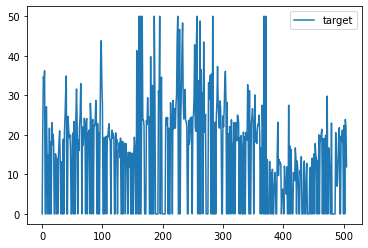

In [29]:
yb2.plot();

In [185]:
## intial estimation, HC3 error

xbs = pd.DataFrame(ss.fit_transform(Xb), columns=Xb.columns)

p0 = 1.5

twd = sma.GLM(endog=yb2, exog=sma.add_constant(xbs), family=sma.families.Tweedie(var_power=p0, eql=True))
res = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                  506
Model:                            GLM   Df Residuals:                      492
Model Family:                 Tweedie   Df Model:                           13
Link Function:                    log   Scale:                          2.3556
Method:                          IRLS   Log-Likelihood:                -2305.0
Date:                Fri, 11 Mar 2022   Deviance:                       2977.4
Time:                        10:23:44   Pearson chi2:                 1.16e+03
No. Iterations:                    25                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6121      0.035     74.398      0.0

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [174]:
print("Estimated Tweedie Power using R Method Built into TweedieElasticNet")
etp = TweedieElasticNet.r_tweedie_power_est(yb2, sma.add_constant(xbs), figsize=None)
print(etp[0])

Estimated Tweedie Power using R Method Built into TweedieElasticNet


R object inheriting from "POSIXct" but without attribute "tzone".


1.1 1.15 1.2 1.25 1.3 1.35 1.4 1.45 1.5 1.55 1.6 1.65 1.7 1.75 1.8 1.85 1.9 
.................Done.
1.1


In [175]:
twd.estimate_tweedie_power(res.mu)

1.0459740194698848

In [179]:
def loglike_p(p, res):
    return -tweedie_dist.tweedie(mu=res.mu, p=p, phi=res.scale).logpdf(res._endog).sum()

def optm(p, res):
    opt = sp.optimize.minimize_scalar(loglike_p, tol=1e-12, 
                                      bounds=(1.05, 1.1), args=(res), method='bounded')
    return opt

print(optm(1.046, res))

     fun: 2133.525669053962
 message: 'Solution found.'
    nfev: 30
  status: 0
 success: True
       x: 1.0999999731254753


In [186]:
optimize_twd_pwr_qd(res.model.endog, res.mu, 1.5, res.model.iweights)

Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.


     fun: 1.73130842995306e-10
 message: 'Solution found.'
    nfev: 24
  status: 0
 success: True
       x: 1.5509765513926428

In [90]:
def loglike_p(p, res):
#     phi = -2*deviance(res.model.endog, res.mu, p).sum()/len(res.model.endog) ## this basically broke everything
#     phi = res.scale
    phi = dispersion(res.model.endog, res.mu).sum()
#     return -2*tweedie_dist.tweedie(mu=res.mu, p=p, phi=phi).logpdf(res._endog).sum()
#     return -2*np.sum(np.log(tweedie_dist.tweedie(mu=res.mu, p=p, phi=phi).pdf(res.model.endog)))

    return tweedie_dist.estimate_tweedie_loglike_series(res.model.endog, res.mu, 
                                                        res.scale*np.ones(len(res.model.endog)), 
                                                        p*np.ones(len(res.model.endog)), ).sum()

def tweedie_profile(X, y, p, tolf=1e-6):
    tol0 = 1
    iters = 0
    while (tol0 > tolf) | (iters<=100):
        p0 = p
        mod = sma.GLM(endog=y, exog=X, family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
        res = mod.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
    
        opt = sp.optimize.minimize_scalar(loglike_p, bounds=(1.05, 1.95), args=(res), method='bounded', tol=1e-20)
        p = opt.x
        tol0 = p0 - p
        iters+=1
    
    return p

tweedie_profile(sma.add_constant(xbs), yb2, p0)

1.9499999583462466

### Dunn and Smyth 2005 Series Expansion

In [239]:
## I see where I am at now relative to R
## jmax estimate - @ dtweedie.jw.smallp <- function(y, phi, power )
def jw_smallp(power, y, phi):
    '''p is power, a is alp'''
    from scipy.special import gammaln, gamma
    
    p = power
    a = (2-p)/(1-p)
    a1 = 1 - a
    r = -a*np.log(y) + a*np.log(p-1) - a1*np.log(phi) - np.log(2-p) # All terms to power j

    drop = 37             # Accuracy of terms: exp(-37)
    # Find limits of summation using Stirling's approximation
    # to approximate gamma terms, and find max as j.max
    logz = max(r)   # To find largest  j  needed
    j_max = max( y**( 2-p ) / ( phi * (2-p) ) )
    j = max( 1, j_max )
    
    c = logz + a1 + a*np.log(-a)
    wmax = a1*j_max
    estlogw = wmax
  
    # First, the upper limit of j
    while estlogw > (wmax-drop):
        j = j + 2
        estlogw = j*(c - a1*np.log(j))
         
    hi_j = np.ceil(j)
    
    # Now the lower limit of j
    logz = min(r) 
    j_max = min( y**( 2-power ) / ( phi * (2-power) ) )
    
    j = max(1, j_max)
    wmax = a1*j_max 
    estlogw = wmax 
    while (estlogw > (wmax-drop)) & (j>=2):
        j = max(1, j-2)
        oldestlogw = estlogw
        estlogw = j*(c-a1*np.log(j))
    
    lo_j = max(1, np.floor(j))            
    # Now sum the series between established limits.
    # We ensure it works for vector y.
    j = np.arange(lo_j, hi_j + 1) ## j <- seq( lo.j, hi.j)  # sequence of j terms needed
    o = np.ones((len(y),1)) ## o <- matrix( 1, nrow=length(y))     # matrix of ones
    
    g = (gammaln(j+1) + gammaln(-a*j)).reshape(-1,1)  ## g <- matrix(lgamma( j+1 ) + lgamma( -a*j ), nrow=1, ncol=hi.j - lo.j + 1) 
    og = o.dot(g.T) ## logj <- matrix(log(j), nrow=1, ncol=hi.j - lo.j + 1) 
    logj = np.log(j).reshape(-1,1) ## og <- o %*% g  # matrix of gamma terms
    ologj = o.dot(logj.T) ## ologj <- o %*% logj

    A = np.outer(r,j) - og + ologj # the series almost ready to sum   A <- outer(r,j) - og + ologj
    m = np.max(A, axis=1).reshape(-1,1) # avoid overflow, find max values  m <- apply(A,1,max)
    we = np.exp(A - m) ## we <- exp( A - m )  # evaluate terms, less max.
    we_sum = np.sum(we, axis=1) ## sum.we <- apply( we,1,sum)  # sum terms
    
    #     jw <- sum.we * exp( m )                # now restore max.
    #     # Since derivs may be negative, can't use log-scale
    jw = we_sum * np.exp(m) 
    
    return hi_j, lo_j, j, jw, m

In [141]:
## I see where I am at now relative to R
## jmax estimate - @ dtweedie.jw.smallp <- function(y, phi, power )

# def logl(phi, y, mu, power):
#     return np.sum(np.log())

def logw_smallp(power, y, phi):
    '''p is power, a is alp'''
    from scipy.special import gammaln, gamma
    
    p = power
    a = (2-p)/(1-p)
    a1 = 1 - a
    r = -a*np.log(y) + a*np.log(p-1) - a1*np.log(phi) - np.log(2-p) # All terms to power j

    drop = 37             # Accuracy of terms: exp(-37)
    # Find limits of summation using Stirling's approximation
    # to approximate gamma terms, and find max as j.max
    logz = max(r)   # To find largest  j  needed
    j_max = max( y**( 2-p ) / ( phi * (2-p) ) )
    j = max( 1, j_max )
    
    c = logz + a1 + a*np.log(-a)
    wmax = a1*j_max
    estlogw = wmax
  
    # First, the upper limit of j
    while estlogw > (wmax-drop):
        j = j + 2
        estlogw = j*(c - a1*np.log(j))
         
    hi_j = np.ceil(j)
    
    # Now the lower limit of j
    logz = min(r) 
    j_max = min( y**( 2-power ) / ( phi * (2-power) ) )
    
    j = max(1, j_max)
    wmax = a1*j_max 
    estlogw = wmax 
    while (estlogw > (wmax-drop)) & (j>=2):
        j = max(1, j-2)
        oldestlogw = estlogw
        estlogw = j*(c-a1*np.log(j))
    
    lo_j = max(1, np.floor(j))            
    # Now sum the series between established limits.
    # We ensure it works for vector y.
    j = np.arange(lo_j, hi_j + 1) ## j <- seq( lo.j, hi.j)  # sequence of j terms needed
    o = np.ones((len(y),1)) ## o <- matrix( 1, nrow=length(y))     # matrix of ones
    
    g = (gammaln(j+1) + gammaln(-a*j)).reshape(-1,1)  ## g <- matrix(lgamma( j+1 ) + lgamma( -a*j ), nrow=1, ncol=hi.j - lo.j + 1) 
    og = o.dot(g.T) ## logj <- matrix(log(j), nrow=1, ncol=hi.j - lo.j + 1) 
    #logj = np.log(j).reshape(-1,1) ## og <- o %*% g  # matrix of gamma terms
    #ologj = o.dot(logj.T) ## ologj <- o %*% logj

    A = np.outer(r,j) - og # + ologj # the series almost ready to sum   A <- outer(r,j) - og + ologj
    m = np.max(A, axis=1).reshape(-1,1) # avoid overflow, find max values  m <- apply(A,1,max)
    we = np.exp(A - m) ## we <- exp( A - m )  # evaluate terms, less max.
    we_sum = np.sum(we, axis=1) ## sum.we <- apply( we,1,sum)  # sum terms
    
    logw = np.log(we_sum) + m
    
    return hi_j, lo_j, j_max, logw

In [160]:
def tseries(power, y, mu, phi):
    
    res = logw_smallp(power, y, phi)
    logw = res[-1]
    logw = np.where(~(np.isfinite(logw)), 0, logw)
    
    tau = phi*(power-1)*mu**(power-1)
    lam = mu**(2-power) / (phi*(2-power))
#     print(y.shape, tau.shape, lam.shape, logw.shape)
#     print(logw.sum()) ## not nan
    logf = -y/tau - lam + np.log(y) + logw.sum()
    f = np.exp(logf)
    density = f
    
    return density, logw

In [161]:
# for p in np.arange(1.05,1.95,.05):
#     dens, logw = tseries(p, twd.endog, res.mu, res.scale)
#     print(dens.sum())

In [164]:
mu = res.mu
phi = res.scale
p = 1.5

lam = mu**(2-p) / (phi*(2-p))
alp = (2-p)/(1-p)
gam = phi*(p-1) * mu**(p-1)

jms = []
for p in np.arange(1.05, 1.95, .01):
    
    mod1 = sma.GLM(endog=yf, exog=sma.add_constant(xfs),  
                   family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
    res1 = mod1.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
    phi = res1.scale
#     phi = dispersion(yf, res1.mu)
    mu = res1.mu
    
    alp = (2-p)/(1-p)
#     jw = jw_smallp(p, yf, alp, phi)

#     jw = logw_smallp(p, yf, phi)
    
    jw = tseries(p, yf, mu, phi)
    
    jms.append((p,np.ma.masked_invalid(jw[-1]).sum()))
    
    q = sma.add_constant(xfs).shape[1]
    n = len(yf)
    dev = res1.deviance
    new_scale = 1/(n-q) * np.ma.masked_invalid(jw[-1]*dev).sum() 
#     print(new_scale, p)
    
#     print(p, np.ma.masked_invalid(jmax[-1]).sum())


In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
divide by zero encountered in log
invalid value encountered in subtract
overflow encountered in exp


<AxesSubplot:xlabel='pwr'>

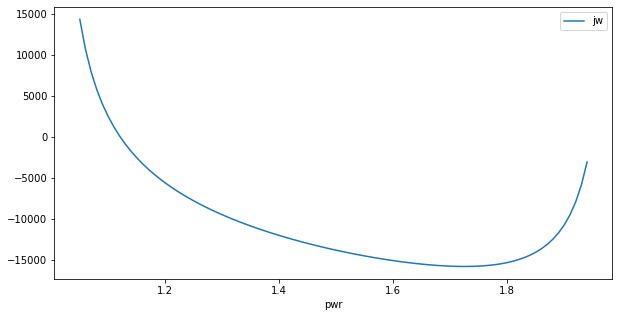

In [165]:
fig, ax=plt.subplots(1,1,figsize=(10,5))
pd.DataFrame(jms, columns=['pwr','jw']).set_index('pwr').plot(ax=ax)
# ax.axvline(np.argmin(jms[0,:]), color='r', alpha=0.5);

In [37]:
from scipy.special import factorial, gammaln, gamma

mu = res.mu
phi = res.scale
# p = 1.5

chk = []
powers = np.arange(1.05,2.0,0.05)
for p in powers:
    
    lam = mu**(2-p) / (phi*(2-p))
    alp = (2-p)/(1-p)
    gam = phi*(p-1) * mu**(p-1)

    p_yat0 = np.exp(-lam)
    # print(p_yat0)

    ## for y>0

    Wj = 0
    for j in range(10):
        ja = j*alp
        num = y**(-ja) * (p-1)**(ja)
        den = phi**(j-ja) * (2-p)**j * factorial(j) * gamma(-ja)
        Wj += num/den

    W_yp = Wj

    a_yphi = 1/y * W_yp

#     print(f"mu = {mu[:5]},\n phi = {phi},\n p={p}, \n P(y==0) = {p_yat0[:5]}")
#     print(f"a(y,phi) = {a_yphi[:10].flatten()}")

    ## page 7 appropriate j value

    z_num = y**(-alp) * (p-1)**(alp)
    z_den = phi**(1-alp) * (2-p)
    z = z_num/z_den

#     print(j)
    log_Wj = -np.log(2*np.pi) - 1/2 * np.log(-alp) - np.log(j)
    dlogW_dj = np.log(z) - np.log(j) + alp*(np.log(-alp*j))

    j_max = y**(2-p)/(phi*(2-p))
#     print(j_max[:5].flatten())

    log_Wmax = j_max*(alp-1) - np.log(2*np.pi) - np.log(j_max) - 1/2 * np.log(-alp)
#     print(log_Wmax[:5].flatten())

    ## need to bound from page 9?

    wj = np.exp(np.log(Wj) - log_Wmax)

    ## wj is a sum from lower bound to upperbound
    logW_hat = log_Wmax + np.log(wj)

    print(p, np.nansum(logW_hat), np.nansum(j_max))
    chk.append(np.nansum(logW_hat))

1.05 -718.7762212459988 100.63454765629359
1.1 331.7308088689721 92.16624100051672
1.1500000000000001 138.53520734819384 85.09742130186255
1.2000000000000002 40.98052186430239 79.24219475848511
1.2500000000000002 -17.480176511117858 74.45440291613642
1.3000000000000003 -55.98747843646685 70.62319023358512
1.3500000000000003 -82.91702534930923 67.67054976007515
1.4000000000000004 -102.50711265153171 65.55110608623963
1.4500000000000004 -117.08068083514351 64.25478704603412
1.5000000000000004 -127.96574025367843 63.81373360469741
1.5500000000000005 -135.91736723094354 64.31615183429254
1.6000000000000005 -141.3112614122152 65.9326524354074
1.6500000000000006 -144.21038947360836 68.96708524796185
1.7000000000000006 -144.3278211825073 73.96000082596916
1.7500000000000007 -140.8368220945306 81.91799143333931
1.8000000000000007 -131.82022494783877 94.88877645054589
1.8500000000000008 -112.55894680953776 117.68831794398466
1.9000000000000008 -68.63230555614659 164.81153106568033
1.95000000000

overflow encountered in multiply
overflow encountered in double_scalars
invalid value encountered in true_divide
overflow encountered in power
divide by zero encountered in true_divide
invalid value encountered in multiply
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in add


In [68]:
saddle = np.sum(res.deviance)/len(y)
saddle

3.4362219562028185

In [69]:
# lower_lim = min([0.001, saddle/2])
# upper_lim = 10*phi
# print(lower_lim, upper_lim)

**The paper says they use BFGS solver with first derivative - dlogfdphi**

In [70]:
# ## adjust profile likihood (page 14) Cox and Reid 87
# q = X.shape[1]
# D = np.eye(len(X))*weights

# apl = llf + q/2*np.log(phi) - 1/2*np.abs(np.log(X).T.D.X)

In [71]:
sig = dispersion(yf, res.mu)
sig.shape

(250,)

In [72]:
# np.log(yf)

In [73]:
poy = np.linspace(1.05, 1.95, len(yf)) #$np.arange(1.05, 2.0, 1/len(yf))
len(yf), len(poy)

(250, 250)

- https://github.com/statsmodels/statsmodels/issues/2915
- https://github.com/statsmodels/statsmodels/pull/3079
- https://github.com/statsmodels/statsmodels/issues/2858

In [80]:
# #  box cos log likelihood

# powers = np.arange(1.05,1.95,0.01)
# for p in powers:
#     p = p.round(2)
#     mod2 = sma.GLM(endog=yf, exog=sma.add_constant(xfs),  
#                    family=sma.families.Tweedie(var_power=p, eql=True), offset=None)
#     res2 = mod2.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
#     sig = dispersion(yf, res2.mu)
    
# #     phin = res2.scale*np.ones(len(yf))
#     phin = dispersion(yf, res2.mu)
    
#     pn = p*np.ones(len(yf))
#     tmp = tweedie_dist.estimate_tweedie_loglike_series(yf, res2.mu, phin, pn)
    
#     chk = -1/2 *np.sum( np.log(2*np.pi*sig**2) + ((yf - res2.mu)/sig)**2 + p*np.log(yf).replace(-np.inf,0) )
#     print(p, chk, np.nansum(tmp))

Nope

In [78]:
# (1.5+1.25)/2

1.375

In [54]:
phin = dispersion(yf, res2.mu)
phin

0     -92.592289
1     -92.161732
2     -92.353539
3     -92.476091
4     -92.721800
         ...    
245   -91.211999
246   -92.621994
247   -92.476091
248   -92.584630
249   -92.476091
Name: FISH_COUNT, Length: 250, dtype: float64

In [55]:
# tmp = tweedie_dist.estimate_tweedie_loglike_series(yf, res2.mu, phin, poy)
## too long

pn = 1.5*np.ones(len(yf))

tmp = tweedie_dist.estimate_tweedie_loglike_series(yf, res2.mu, phin, pn)

In [56]:
tmp.sum()

-814.0612978964955

In [9]:
sas_power = 1.4023

twd = sma.GLM(endog=y, exog=sma.add_constant(xfs), 
              family=sma.families.Tweedie(var_power=sas_power, eql=True))

print("="*20," Normal Fit ","="*20)
tfit = twd.fit(maxiter=1000, tol=1e-12)
print(tfit.cov_type)
print(tfit.summary())

print("="*20," HC3 Fit ","="*20)
tfit_hc3 = twd.fit(cov_type='HC3', maxiter=1000, tol=1e-12)
print(tfit_hc3.cov_type)
print(tfit_hc3.summary().tables[1])

print("="*20," HAC (NeweyWest) Fit ","="*20)
tfit_nw = twd.fit(cov_type='HAC', cov_kwds={'maxlags':12}, maxiter=1000, tol=1e-12)
print(tfit_nw.cov_type)
print(tfit_nw.summary().tables[1])

====================  Normal Fit  ====================
nonrobust
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      245
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    log   Scale:                          7.6404
Method:                          IRLS   Log-Likelihood:                -554.54
Date:                Thu, 03 Mar 2022   Deviance:                       841.62
Time:                        17:28:57   Pearson chi2:                 1.87e+03
No. Iterations:                    18                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


In [10]:
# tfit.wald_test(tfit.resid_working)

### Comparison with R

link.power = 0 is the log link

**R Code:**

library(tweedie)
library(statmod)
library(lmtest)
library(sandwich)

df <- read.csv(data='data/fish.csv')

m1 <- glm(FISH_COUNT~., data=df, family=tweedie(var.power=1.4, link.power=0))

summary(m1)

coeftest(m1, vcov=vcovHC(m1, type='HC3'))

coeftest(m1, vcov=NeweyWest(m1, lag=12, prewhite=F))

In [11]:
from statsmodels.iolib import SimpleTable
from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)

In [12]:
def r_summary_model(model, X):
    """ Create a dict with information about the model """
    import datetime as dt
    from statsmodels.iolib import SimpleTable
    from statsmodels.iolib.tableformatting import (gen_fmt, fmt_2, fmt_params)
    from statsmodels.iolib.summary import forg
#         model = self.model

    info = {}
    info['Model:'] = 'Tweedie with Varying Error Types'
    info['Date:'] = dt.datetime.now().strftime('%Y-%m-%d %H:%M')
    info['Df Model:'] = rbase.summary(model).rx2('df')[0]
    info['Df Residuals:'] = model.rx2('df.residual')[0]
#     info['Converged:'] = rbase.summary(model).rx2('converged')[0]
    info['Deviance:'] = rbase.summary(model).rx2('deviance')[0]
    info['Dispersion:'] = rbase.summary(model).rx2('dispersion')[0]
    info['Iters:'] = rbase.summary(model).rx2('iter')[0]

    out = pd.DataFrame(info, index=range(len(info))).T.iloc[:,0]
    model_coefs = rbase.summary(model).rx2('coefficients')
    orig_data = model.rx2('model')
    var_names = ['Intercept'] + list(X.columns) #self.X.columns)
    
    cov = rbase.summary(model).rx2('cov.scaled')

    model_data = list(info.items())
    mt = SimpleTable(model_data, txt_fmt=fmt_params)

    params_data = []
    for i in range(model_coefs.shape[0]):
        curr_row = model_coefs[i,:]
#         params_data.append([forg(j, prec=4) for j in curr_row])
        params_data.append([np.round(j,5) for j in curr_row])
    pt = SimpleTable(params_data, ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                     var_names, txt_fmt=fmt_params)
    return mt, pt

In [13]:
mass = importr('MASS')
rstats = importr('stats')
robustbase = importr('robustbase')
rbase = importr('base')
rsm = importr('statmod')
rsw = importr('sandwich')
r_lmt = importr('lmtest')

R object inheriting from "POSIXct" but without attribute "tzone".


In [14]:
yR = pd.Series(y.flatten())
yR.name = 'y'

rdf = pd.concat([yR,xfs], axis=1)
rdf.head()

y  LIVE_BAIT  CAMPER  PERSONS  CHILDREN
0  0          0       0        1         0
1  0          1       1        1         0
2  0          1       0        1         0
3  0          1       1        2         1
4  1          1       0        1         0

In [15]:
## tukey defaults are S=1.55, M=4.69
cntrl_str = '''maxit=1000'''
cntrl = robjects.r('a1 <- glm.control({})'.format(cntrl_str)) 

model = rstats.glm('{} ~ .'.format(yR.name), 
                  data=rdf, family=robjects.r('tweedie(var.power={}, link.power=0)'.format(sas_power)),
                  control=cntrl)
model_coefs = rbase.summary(model).rx2('coefficients')

In [16]:
print("R Model","="*30)
for item in r_summary_model(model, X):
    print(item)

print("Statsmodels","="*30)
print(tfit.summary().tables[1])

R Model ==============================
       Model: Tweedie with Varying Error Types
        Date:                 2022-03-03 17:29
    Df Model:                                5
Df Residuals:                              245
    Deviance:                841.6208938250044
  Dispersion:                7.640315118546264
       Iters:                                5
             Estimate Std. Error    t value   Pr(>|t|)
------------------------------------------------------
Intercept    -3.11477    0.72067   -4.32203      2e-05
LIVE_BAIT     1.58167    0.62332     2.5375    0.01179
CAMPER        0.64541    0.31049    2.07866    0.03869
PERSONS       1.05683    0.13264    7.96788        0.0
CHILDREN     -1.77527    0.24616   -7.21193        0.0
Statsmodels ==============================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.721     -4.322   

In [17]:
var_names = ['Intercept'] + list(xfs.columns)

hc3_params = r_lmt.coeftest(model, vcov=rsw.vcovHC(model, type="HC3"))

st = SimpleTable(hc3_params.round(4), ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                 var_names, txt_fmt=fmt_params)

print("R Model","="*30)
print(st)
print("Statsmodels","="*30)
print(tfit_hc3.summary().tables[1])

R Model ==============================
             Estimate Std. Error    t value   Pr(>|t|)
------------------------------------------------------
Intercept     -3.1148     0.5111    -6.0943        0.0
LIVE_BAIT      1.5817     0.3869     4.0885        0.0
CAMPER         0.6454     0.3458     1.8662      0.062
PERSONS        1.0568     0.1196     8.8386        0.0
CHILDREN      -1.7753     0.2308    -7.6913        0.0
Statsmodels ==============================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.471     -6.614      0.000      -4.038      -2.192
LIVE_BAIT      1.5817      0.372      4.249      0.000       0.852       2.311
CAMPER         0.6454      0.337      1.913      0.056      -0.016       1.307
PERSONS        1.0568      0.116      9.145      0.000       0.830       1.283
CHILDREN      -1.7753      0.241     -7.362      0.000     

In [18]:
nw_params = r_lmt.coeftest(model, vcov=rsw.NeweyWest(model, lag=12))

st = SimpleTable(nw_params.round(4), ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)'],
                 var_names, txt_fmt=fmt_params)

print("R Model","="*30)
print(st)
print("Statsmodels","="*30)
print(tfit_nw.summary().tables[1])

R Model ==============================
             Estimate Std. Error    t value   Pr(>|t|)
------------------------------------------------------
Intercept     -3.1148     0.4899    -6.3585        0.0
LIVE_BAIT      1.5817     0.3295     4.7998        0.0
CAMPER         0.6454     0.3071     2.1016     0.0356
PERSONS        1.0568     0.1131      9.342        0.0
CHILDREN      -1.7753     0.2196    -8.0835        0.0
Statsmodels ==============================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.478     -6.519      0.000      -4.051      -2.178
LIVE_BAIT      1.5817      0.331      4.773      0.000       0.932       2.231
CAMPER         0.6454      0.305      2.116      0.034       0.048       1.243
PERSONS        1.0568      0.113      9.316      0.000       0.834       1.279
CHILDREN      -1.7753      0.235     -7.547      0.000     

In [19]:
tfit_nw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                            GLM   Df Residuals:                      245
Model Family:                 Tweedie   Df Model:                            4
Link Function:                    log   Scale:                          7.6404
Method:                          IRLS   Log-Likelihood:                -554.54
Date:                Thu, 03 Mar 2022   Deviance:                       841.62
Time:                        17:29:21   Pearson chi2:                 1.87e+03
No. Iterations:                    18                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1148      0.478     -6.519      0.000      -4.051      -2.178
LIVE_BAIT      1.5817      0.331      4.773      0.000       0.932       2.231
CAMPER         0.6454      0.305      2.116      0.034       0.048       1.243
PERSONS        1.0568      0.113      9.316      0.000       0.834       1.279
CHILDREN      -1.7753      0.235     -7.547      0.000      -2.236      -1.314
==============================================================================
"""

In [28]:
os.getcwd()

'C:\\Users\\schillw\\OneDrive - FNBCorp\\CECL 2020-2021\\tweedie_huber_info_v2'

In [51]:
def tweedie_rout(y, X, power, path, segment):
    '''Writes an R script for ease of checking to the specified path portion.
       The path already pulls in the current working directory of the notebook.
       Returns the r_data and the script.
    '''
    import os

    cwd = os.getcwd()
    data = pd.concat([y,X],axis=1).dropna()
    data.to_csv(cwd+path+'/r_data.csv', index=False)

    y_name = data.columns[0]

    script = '''
        Packages <- c("tweedie", "statmod", "lmtest", "sandwich")
        lapply(Packages, library, character.only = TRUE)

        print("Read in the data ===================")
        df <- read.csv(file='r_data.csv')
        print("Run the Model ======================")
        m <- glm('{}~.', data=df, family=tweedie(var.power={}, link.power=0))
        print("Summary ============================")
        summary(m)
        print("Newey-West Robust Errors ===========")
        coeftest(m, vcov=NeweyWest(m, lag=12, prewhite=F))
        '''.format(y_name, power)

    with open(cwd+path+'/r_code_{}.r'.format(segment), 'w') as f:
        f.write(script)

    return data, script

In [52]:
tweedie_rout(yR, xfs, 1.4, path='/r_out_test', segment='test')

(     y  LIVE_BAIT  CAMPER  PERSONS  CHILDREN
 0    0          0       0        1         0
 1    0          1       1        1         0
 2    0          1       0        1         0
 3    0          1       1        2         1
 4    1          1       0        1         0
 ..  ..        ...     ...      ...       ...
 245  0          1       1        2         0
 246  0          1       1        4         3
 247  0          1       1        2         1
 248  0          1       1        3         2
 249  0          1       1        2         1
 
 [250 rows x 5 columns],
 '\n        Packages <- c("tweedie", "statmod", "lmtest", "sandwich")\n        lapply(Packages, library, character.only = TRUE)\n\n        print("Read in the data ===================")\n        df <- read.csv(file=\'r_data.csv\')\n        print("Run the Model ======================")\n        m <- glm(\'y~.\', data=df, family=tweedie(var.power=1.4, link.power=0))\n        print("Summary ============================")\

In [ ]:
break